# Fit using sqrt and log

In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\Varios_vecinos\\venv\\src')

In [2]:
%pylab inline

from pathlib import Path

import h5py
import numpy as np
import style
from ising.io import read_ising_config
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.optimize import least_squares, differential_evolution, minimize
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re

yaml = YAML()

Populating the interactive namespace from numpy and matplotlib


## Model
El modelo a utilizar es:
$$ \frac{1}{T} = a_1 + \sqrt{-\ln(1 + a_2x +x^{a_3})} $$ 

In [3]:
def model_function(x: float,a1: float,a2: float,a3: float):
    return a1 + np.sqrt(-np.log(1+a2*x+x**a3))

In [4]:
def get_extrapol_function(model_function,a1,a2,a3):
    def extrapol_funct(x):
        return model_function(x,a1,a2,a3)
    return extrapol_funct

## Read files

In [5]:
data_path = Path("../../../data/").resolve()
file = 'all_inv_Tc.csv'
df_all_tc = pd.read_csv(os.path.join(data_path,file))

In [6]:
df_all_tc

,1/nv,P1.0,P1.1,P1.2,P1.3,P1.4,P1.5,P1.6,P1.7,P1.8,P1.9,P2.0
0,0.500000,0.662721,0.680297,0.700150,0.717028,0.734866,0.751727,0.770168,0.786703,0.803441,0.820681,0.835529
1,0.333333,0.505386,0.528284,0.546419,0.574539,0.597153,0.619581,0.642793,0.665299,0.687169,0.709461,0.732735
2,0.250000,0.425707,0.450768,0.472832,0.501265,0.528284,0.555318,0.580268,0.606328,0.631346,0.656782,0.680642
3,0.200000,0.375812,0.402337,0.429970,0.456688,0.485307,0.512765,0.541671,0.569954,0.598822,0.626314,0.653388
4,0.166667,0.341083,0.368523,0.396765,0.424721,0.455167,0.486573,0.515543,0.545704,0.574864,0.605612,0.634517
5,0.142857,0.315105,0.343136,0.372431,0.401683,0.432891,0.463020,0.495621,0.527741,0.560164,0.590963,0.622788
6,0.125000,0.294999,0.323355,0.353053,0.383836,0.415381,0.447872,0.480460,0.513612,0.546888,0.579394,0.611867
7,0.111111,0.278617,0.307334,0.337482,0.368796,0.401333,0.434561,0.468367,0.502578,0.536848,0.570911,0.604637
8,0.100000,0.265052,0.293982,0.324509,0.356434,0.389497,0.423546,0.458147,0.493491,0.528531,0.563834,0.598451
9,0.090909,0.253624,0.282715,0.313452,0.345748,0.379390,0.414121,0.449594,0.485589,0.521795,0.558070,0.593677


In [7]:
df_params = pd.DataFrame(index=["a1","a2","a3"])
df_extrapol_val = pd.DataFrame(index=["infty","1"])

C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


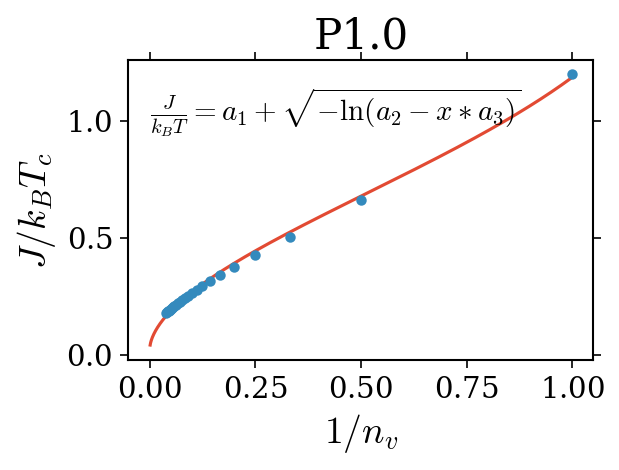

a1: 0.03627576427437284
a2: -1.7328841812080087
a3: 0.9178268728649082
Extrapolation:
0.03627576427437284 at 1/nv=0
1.1852200346327373 at 1/nv=1
min:0.03627576427437284 at 0.0




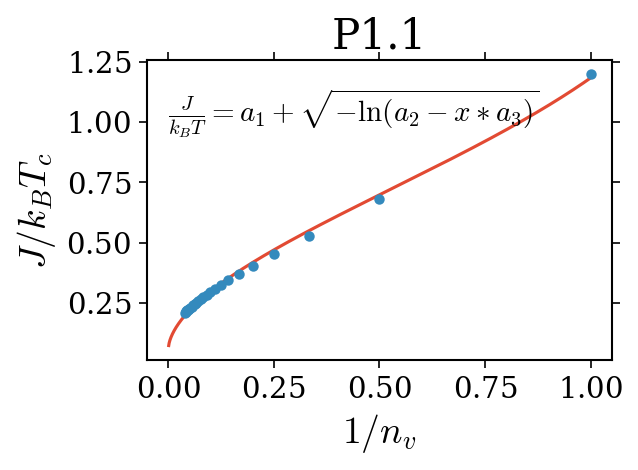

a1: 0.06910508383563455
a2: -1.711224104297183
a3: 0.9185015086890604
Extrapolation:
0.06910508383563455 at 1/nv=0
1.1836024320063936 at 1/nv=1
min:0.06910508383563455 at 0.0




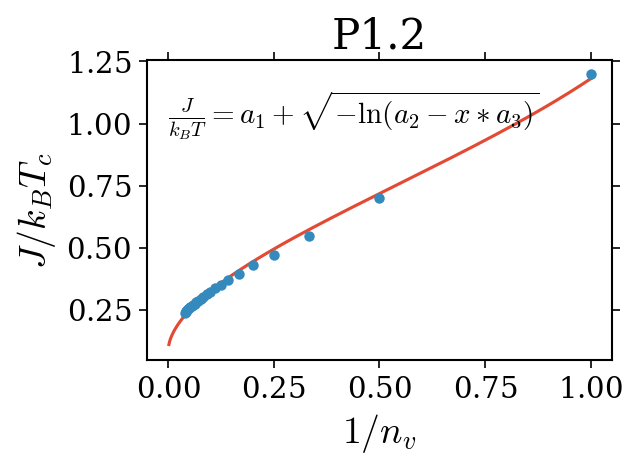

a1: 0.10452130056514215
a2: -1.6858544843922765
a3: 0.9191348543656639
Extrapolation:
0.10452130056514215 at 1/nv=0
1.1805784435273612 at 1/nv=1
min:0.10452130056514215 at 0.0




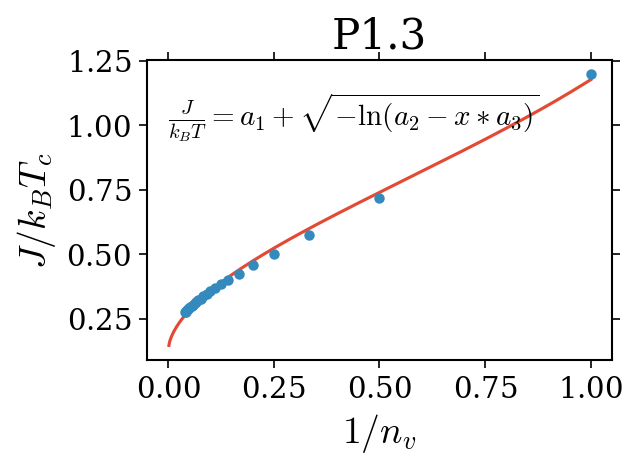

a1: 0.14290329658156847
a2: -1.6572134173681639
a3: 0.9197528911711985
Extrapolation:
0.14290329658156847 at 1/nv=0
1.1776241447036206 at 1/nv=1
min:0.14290329658156847 at 0.0




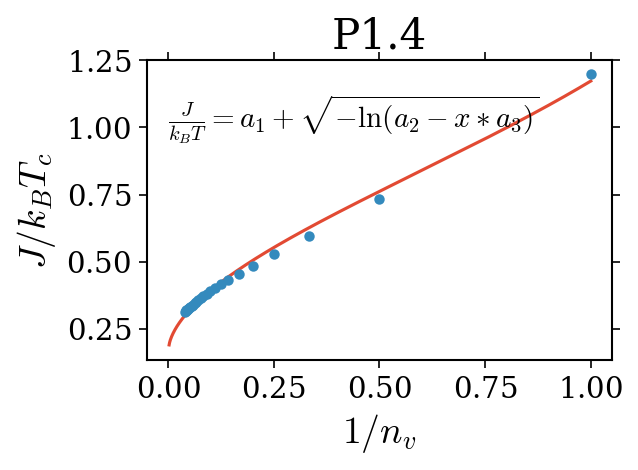

a1: 0.18379257151699024
a2: -1.6242449787219242
a3: 0.9206974218110164
Extrapolation:
0.18379257151699024 at 1/nv=0
1.1731448278393628 at 1/nv=1
min:0.18379257151699024 at 0.0




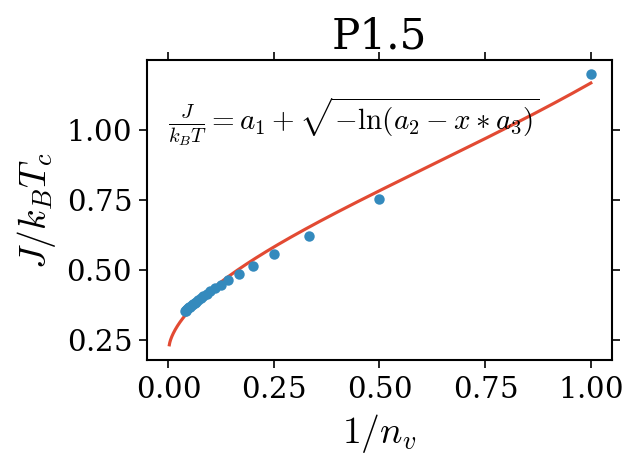

a1: 0.22702780619038282
a2: -1.5868373143091217
a3: 0.922037119066239
Extrapolation:
0.22702780619038282 at 1/nv=0
1.16719473365574 at 1/nv=1
min:0.22702780619038282 at 0.0




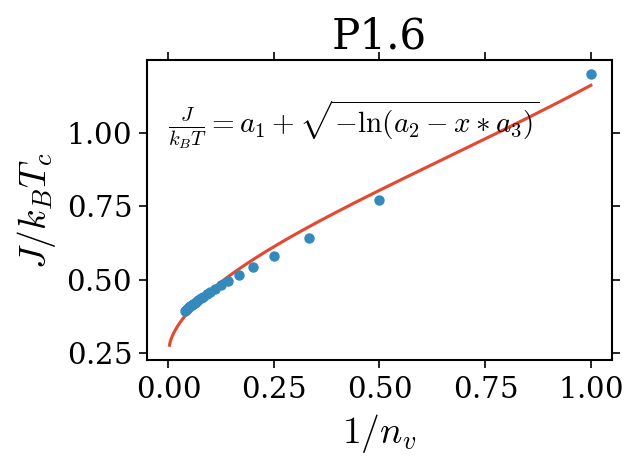

a1: 0.2722973586440376
a2: -1.5458500745688661
a3: 0.9238661061412446
Extrapolation:
0.2722973586440376 at 1/nv=0
1.1607386359540703 at 1/nv=1
min:0.2722973586440376 at 0.0




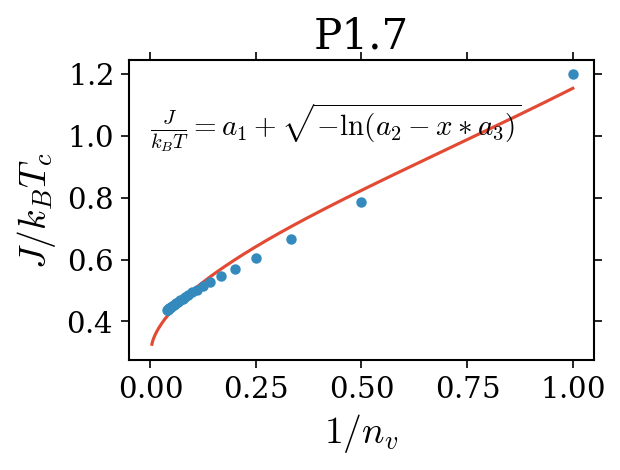

a1: 0.31926167038539055
a2: -1.5010379036574029
a3: 0.9265228627065203
Extrapolation:
0.31926167038539055 at 1/nv=0
1.1530632926846875 at 1/nv=1
min:0.31926167038539055 at 0.0




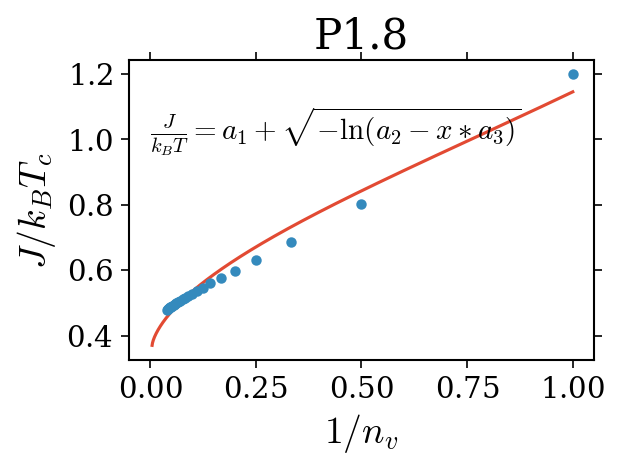

a1: 0.3673263770062839
a2: -1.4536925720180454
a3: 0.9299867351091408
Extrapolation:
0.3673263770062839 at 1/nv=0
1.144869563447505 at 1/nv=1
min:0.3673263770062839 at 0.0




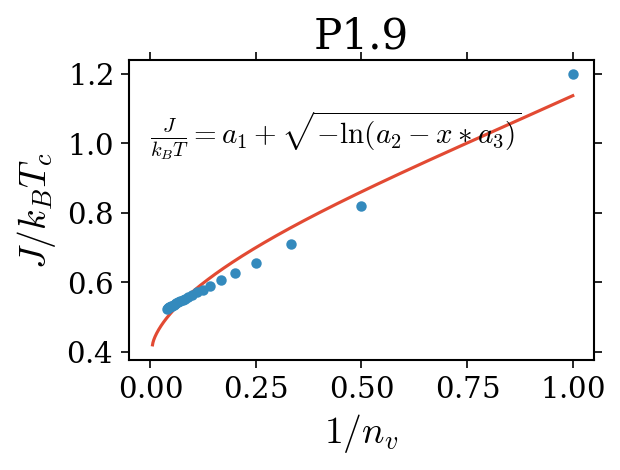

a1: 0.41580315765838627
a2: -1.4055471393558783
a3: 0.934230427566185
Extrapolation:
0.41580315765838627 at 1/nv=0
1.1369923550508694 at 1/nv=1
min:0.41580315765838627 at 0.0




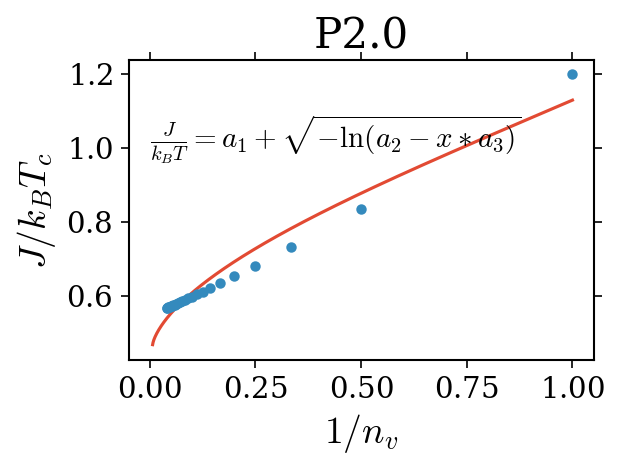

a1: 0.46407760397198294
a2: -1.3572195711991908
a3: 0.9392176141020996
Extrapolation:
0.46407760397198294 at 1/nv=0
1.1288723786026988 at 1/nv=1
min:0.46407760397198294 at 0.0




In [8]:
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
path_save_graph = Path("../../graphs/").resolve()
file_name_base = 'inv_Tc_vs_inv_nv_sqrt_and_log_3_parms_new'
for COLUMN in COLUMNS:
    file_graph = file_name_base + '_{}.png'.format(COLUMN)
    # Get the data in arrays
    df_part = df_all_tc[["1/nv",COLUMN]]
    df_part = df_part.dropna()
    x_data = df_part['1/nv'].values
    y_data = df_part[COLUMN].values
    # add value at nv=1
    x_data = np.concatenate([x_data,[1]])
    y_data = np.concatenate([y_data,[1.19968]])
#     if COLUMN == 'P1.0':
#         #add value at nv=infty
#         x_data = np.insert(x_data,0,0.01)
#         y_data = np.insert(y_data,0,0.01)

#     # for square
#     y_data = y_data**2    

    # fit 
    (a1,a2,a3), _= curve_fit(f=model_function,xdata=x_data,ydata=y_data,maxfev=10000,p0=[0,-1.5,1],
                               bounds=([-1, -3 ,0], [1, -0.1, 2]))
    df_params[COLUMN] = [a1,a2,a3]
    extrapol_funct = get_extrapol_function(model_function, a1,a2,a3)

    # define the point for graph
    x_extrapol = np.linspace(0, 1, 2048)
    y_extrapol = extrapol_funct(x_extrapol)

    # Load the default style.
    style.use("default")
    rcParams["text.usetex"] = False

    fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
    grid_spec = GridSpec(3, 1)

    # Specific heat subplot.
    ax: Axes = fig1.add_subplot(grid_spec[0, 0])

    ax.plot(x_extrapol, y_extrapol, lw=1.5)
    ax.plot(x_data, y_data, marker="o", lw=0)

    ax.set_xlabel(r"$1/n_v$")
    ax.set_ylabel(r"$J/k_BT_c$")
    # add text
    ax.text(0, 1, r"$\frac{J}{k_BT} = a_1 + \sqrt{-\ln{(a_2-x*a_3)}}$")

    ax.set_title(COLUMN)
    pyplot.draw()
#     print('Save graph {}'.format(os.path.join(path_save_graph,file_graph)))
#     pyplot.savefig(os.path.join(path_save_graph,file_graph))
    pyplot.show()
    print("a1: {}\na2: {}\na3: {}".format(a1,a2,a3))
    print("Extrapolation:\n{} at 1/nv=0\n{} at 1/nv=1".format(extrapol_funct(0),extrapol_funct(1)))
    df_extrapol_val[COLUMN] = [extrapol_funct(0),extrapol_funct(1)]  
    print("min:{} at {}".format(np.nanmin(y_extrapol),x_extrapol[np.nanargmin(y_extrapol)]))    
    print("\n")


In [81]:
df_extrapol_val

0.5359269860565828

In [72]:
from scipy.special import zeta
COLUMNS = ["P1.0","P1.1","P1.2","P1.3","P1.4","P1.5","P1.6","P1.7","P1.8","P1.9","P2.0"]
for COLUMN in COLUMNS:
    p = float(COLUMN.replace("P",""))
    df_extrapol_val[COLUMN]['infty'] = df_params[COLUMN]['a1']*(1/zeta(p,df_params[COLUMN]['a2']))

## Save params

In [21]:
file_name_base

'inv_Tc_vs_inv_nv_sqrt_and_log_3_parms_new'

In [22]:
# Define tha path and name for the csv files
file_params = os.path.join(data_path,'Extrapolation',file_name_base+'_params_curves.csv')
file_extrapol_values = os.path.join(data_path,'Extrapolation',file_name_base+'_extrapol_values.csv')
print(df_params)
print("Exporting to csv files the params adjusted {}".format(file_params))
df_params.to_csv(file_params)
print(df_extrapol_val)
print("Exporting to csv files the extrapolation values adjusted {}".format(file_extrapol_values))
df_extrapol_val.to_csv(file_extrapol_values)

        P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
a1  0.939769  0.911871  0.943034  0.980252  1.007151  1.021950  1.029854   
a2  1.007834  0.981732  0.965738  0.949757  0.931099  0.909039  0.884197   
a3 -0.810955 -0.804827 -0.767693 -0.726148 -0.689008 -0.656808 -0.626648   

        P1.7      P1.8      P1.9      P2.0  
a1  1.021900  1.002108  0.975988  0.936500  
a2  0.853074  0.815354  0.771570  0.716729  
a3 -0.600974 -0.576835 -0.551012 -0.523159  
Exporting to csv files the params adjusted C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\data\Extrapolation\inv_Tc_vs_inv_nv_sqrt_and_log_3_parms_new_params_curves.csv
           P1.0      P1.1      P1.2      P1.3      P1.4      P1.5      P1.6  \
infty       NaN  0.123816  0.176079  0.222561  0.269099  0.315595  0.361294   
1      1.198036  1.200121  1.200011  1.199700  1.199500  1.199392  1.199480   

           P1.7      P1.8      P1.9      P2.0  
infty  0.407364  0.452763  0.4970

## Plot extrapol values

C:\Users\MHJGuillermo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


Save graph C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\Varios_vecinos\venv\graphs\Extrapolation\inv_Tc_vs_inv_nv_extrapol_linear_and_zeta_funct_5_parms_all_p.png


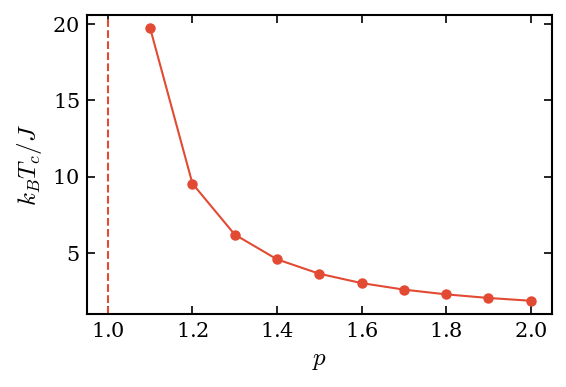

In [78]:
file_extrapol_graph = os.path.join(path_save_graph,'Extrapolation',file_name_base+'_all_p.png')
# data 
x_data = np.arange(1,2.1,0.1)
y_data = 1/df_extrapol_val.loc['infty'].values

# # data for squared 
# y_data = np.sqrt(y_data)

# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

ax.plot(x_data, y_data, marker="o", lw=1)

ax.set_xlabel(r"$p$")
ax.set_ylabel(r"$k_BT_c/J$")
ax.axvline(x=1,linestyle='--')

pyplot.draw()

print('Save graph {}'.format(file_extrapol_graph))
pyplot.savefig(file_extrapol_graph)

pyplot.show()